In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter


In [2]:
def parse_hackrf_sweep_csv(path):
    raw = pd.read_csv(path, header=None)
    parsed_rows = []

    for _, row in raw.iterrows():
        date, time = row[0], row[1]
        hz_low = int(row[2])
        hz_high = int(row[3])
        hz_bin_width = int(row[4])
        num_bins = int((hz_high - hz_low) / hz_bin_width)
        power_vals = row[6:6 + num_bins].astype(float).values

        freqs = np.arange(hz_low, hz_high, hz_bin_width)
        timestamp = f"{date} {time}"

        for f, p in zip(freqs, power_vals):
            parsed_rows.append((timestamp, f, p))

    df = pd.DataFrame(parsed_rows, columns=["timestamp", "frequency", "power"])
    return df


In [3]:
def plot_sweep(df, sweep_idx=0, label=None):
    ts = df['timestamp'].unique()
    if sweep_idx >= len(ts):
        raise IndexError("Sweep index out of range.")
    sweep = df[df['timestamp'] == ts[sweep_idx]]
    plt.plot(sweep['frequency'], sweep['power'], label=label)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title(f"Spectrum at sweep #{sweep_idx}")
    plt.grid()
    if label:
        plt.legend()
    plt.show()

def plot_multiple_sweeps(df, num_sweeps=5):
    unique_ts = df['timestamp'].unique()
    for i in range(min(num_sweeps, len(unique_ts))):
        sweep = df[df['timestamp'] == unique_ts[i]]
        plt.plot(sweep['frequency'], sweep['power'], alpha=0.6, label=f"Sweep {i}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title(f"First {num_sweeps} Sweeps")
    plt.grid()
    plt.legend()
    plt.show()


In [4]:
def plot_aggregate_spectrum(df, label=None):
    grouped = df.groupby("frequency")["power"]
    mean_power = grouped.mean()
    std_power = grouped.std()

    plt.plot(mean_power.index, mean_power.values, label=f"{label} Mean")
    plt.fill_between(mean_power.index,
                     mean_power - std_power,
                     mean_power + std_power,
                     alpha=0.3, label=f"{label} ±1 std")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title("Mean Spectrum ± Std")
    plt.grid()
    if label:
        plt.legend()
    plt.show()


In [5]:
def load_segments_from_metadata(metadata_path, max_total=200):
    rf_entries = []

    rf_meta = pd.read_csv(metadata_path)
    rf_files = list(Path("segments").rglob("rf/*.csv"))

    segment_to_path = {p.parts[-3]: p for p in rf_files}
    rf_meta = rf_meta[rf_meta["segment_id"].isin(segment_to_path)]

    segment_to_label = dict(zip(rf_meta["segment_id"], rf_meta["label"]))

    for segment_id, label in segment_to_label.items():
        path = segment_to_path[segment_id]
        try:
            df = parse_hackrf_sweep_csv(path)
            rf_entries.append({
                "segment": segment_id,
                "label": label,
                "df": df
            })
            if len(rf_entries) >= max_total:
                break
        except Exception as e:
            print(f"Feil i {path}: {e}")
            continue

    return rf_entries


In [6]:
# Last inn mange segmenter
all_segments = load_segments_from_metadata("metadata/metadata_rf.csv", max_total=350)

# Plukk 10 av hver klasse
drone_segments = [s for s in all_segments if s["label"] == "drone"][:10]
no_drone_segments = [s for s in all_segments if s["label"] == "no_drone"][:10]
rf_segments = drone_segments + no_drone_segments

print(f"Bruker {len(rf_segments)} segmenter totalt")
print("Fordeling:", Counter([s["label"] for s in rf_segments]))

# Beregn og plott gjennomsnittsspekter
def average_power_over_segments(segment_list):
    all_power = []
    for df in segment_list:
        mean = df.groupby("frequency")["power"].mean()
        all_power.append(mean)
    if not all_power:
        return None, None
    stacked = pd.concat(all_power, axis=1)
    return stacked.mean(axis=1), stacked.std(axis=1)

mean_d, std_d = average_power_over_segments([s["df"] for s in drone_segments])
mean_n, std_n = average_power_over_segments([s["df"] for s in no_drone_segments])

if mean_d is not None and mean_n is not None:
    plt.plot(mean_d.index, mean_d.values, label="Drone")
    plt.fill_between(mean_d.index, mean_d - std_d, mean_d + std_d, alpha=0.3)

    plt.plot(mean_n.index, mean_n.values, label="No Drone")
    plt.fill_between(mean_n.index, mean_n - std_n, mean_n + std_n, alpha=0.3)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title("Mean Spectrum: Drone vs No Drone")
    plt.grid()
    plt.legend()
    plt.show()
else:
    print("Ingen gyldige segmenter for plotting.")


Feil i segments\seg_00097_aug\rf\rf_drone_outside_aug.csv: division by zero
Feil i segments\seg_00342_aug\rf\rf_drone_outside_aug.csv: division by zero
Bruker 10 segmenter totalt
Fordeling: Counter({'drone': 10})
Ingen gyldige segmenter for plotting.


In [7]:
from matplotlib import pyplot as plt
from datetime import datetime
from collections import defaultdict
import numpy as np
from pathlib import Path

def truncate_to_second(ts: datetime) -> datetime:
    return ts.replace(microsecond=0)

def parse_sweep_line(line: str):
    parts = [p.strip() for p in line.split(',')]
    if len(parts) < 7:
        raise ValueError("Line has fewer than 7 fields")
    ts = truncate_to_second(datetime.strptime(f"{parts[0]} {parts[1]}", "%Y-%m-%d %H:%M:%S.%f"))
    f_start, f_end = float(parts[2]), float(parts[3])
    decl_bins = int(parts[5])
    powers = np.array([float(p) for p in parts[6:]], dtype=float)
    bw = (f_end - f_start) / powers.size
    return ts, f_start, bw, powers

def build_waterfall(path):
    segs_by_sec = defaultdict(list)
    all_segs = []

    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if not line.strip() or line.startswith('#'):
                continue
            try:
                ts, f_start, bw, pwr = parse_sweep_line(line)
            except Exception:
                continue
            segs_by_sec[ts].append((f_start, bw, pwr))
            all_segs.append((f_start, bw, pwr))

    freq_vec = np.unique(np.concatenate([
        f_start + bw * np.arange(pwr.size)
        for f_start, bw, pwr in all_segs
    ]))
    F = freq_vec.size
    times = np.array(sorted(segs_by_sec))
    S = times.size

    freq_to_idx = {f: i for i, f in enumerate(freq_vec)}
    power_mat = np.full((S, F), np.nan, dtype=float)

    for i, t in enumerate(times):
        for f_start, bw, pwr in segs_by_sec[t]:
            centers = f_start + bw * np.arange(pwr.size)
            cols = [freq_to_idx.get(c, None) for c in centers]
            valid = [j for j in zip(cols, pwr) if j[0] is not None]
            for col, val in valid:
                power_mat[i, col] = val

    return times, freq_vec, power_mat

def plot_waterfall(freq_vec, power_db, title, vmin=None, vmax=None):
    data = np.ma.masked_invalid(power_db)
    plt.figure(figsize=(12, 6))
    img = plt.imshow(
        data,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap="viridis",
        extent=[freq_vec[0]/1e6, freq_vec[-1]/1e6, 0, data.shape[0]],
        vmin=vmin,
        vmax=vmax
    )
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Sweep index")
    plt.title(title)
    plt.colorbar(img, label="Power (dBFS)")
    plt.tight_layout()
    plt.show()

# Plott én drone og én no_drone waterfall
drone_file = drone_segments[9]["segment"]
no_drone_file = no_drone_segments[0]["segment"]

drone_path = Path("segments") / drone_file / "rf"
no_drone_path = Path("segments") / no_drone_file / "rf"

drone_csv = list(drone_path.glob("*.csv"))[0]
no_drone_csv = list(no_drone_path.glob("*.csv"))[0]

_, f_d, p_d = build_waterfall(drone_csv)
_, f_n, p_n = build_waterfall(no_drone_csv)


global_min = np.nanmin([p_d, p_n])
global_max = np.nanmax([p_d, p_n])

plot_waterfall(f_d, p_d, f"Drone: {drone_file}", vmin=global_min, vmax=global_max)
plot_waterfall(f_n, p_n, f"No Drone: {no_drone_file}", vmin=global_min, vmax=global_max)



IndexError: list index out of range

In [ ]:
from scipy.signal import welch
import matplotlib.pyplot as plt

def compute_psd(df, sweep_idx=0, fs=1e6, nperseg=256):
    """
    Beregn og plott PSD (Power Spectral Density) for ett sweep i ett segment.
    
    Parameters:
    - df: DataFrame med long-format fra parse_hackrf_sweep_csv
    - sweep_idx: hvilken sweep i df (tidsindeks)
    - fs: "sampling rate" over frekvensbinene, brukes for aksen
    - nperseg: segmentlengde for Welch (flere = jevnere kurve, færre = grovere)
    """
    ts = df['timestamp'].unique()
    sweep = df[df['timestamp'] == ts[sweep_idx]]
    power = sweep['power'].values
    f, Pxx = welch(power, fs=fs, nperseg=nperseg)
    plt.semilogy(f, Pxx)
    plt.title(f"PSD – Sweep #{sweep_idx}")
    plt.xlabel("Frequency bin index")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.show()



In [ ]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

def compute_segment_psd(df, fs=1e6, nperseg=512):
    """
    Beregn og plott PSD over hele segmentet (alle sweeps concatenated).
    
    Parameters:
    - df: long-format DataFrame med 'timestamp', 'frequency', 'power'
    - fs: "sample rate" i Hz (brukes kun som skala på x-aksen)
    - nperseg: segmentlengde for Welch
    """
    # Konkatener alle power-verdier etter sweep-rekkefølge
    all_powers = []
    for ts in df['timestamp'].unique():
        sweep = df[df['timestamp'] == ts]
        all_powers.append(sweep['power'].values)
    power_vec = np.concatenate(all_powers)

    # PSD-estimering
    f, Pxx = welch(power_vec, fs=fs, nperseg=nperseg)
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx)
    plt.title("PSD over hele segmentet")
    plt.xlabel("Bin rate (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.tight_layout()
    plt.show()


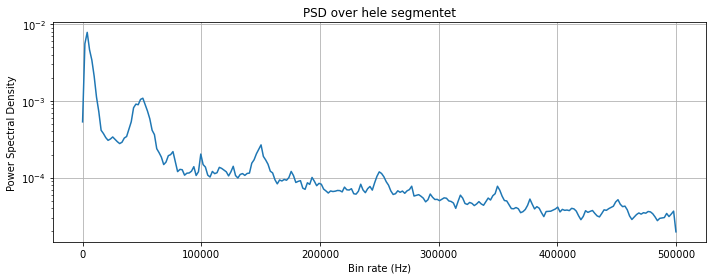

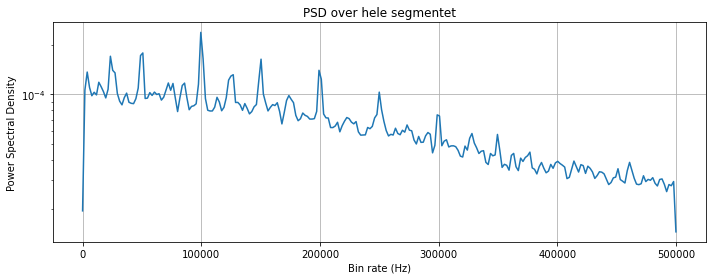

In [ ]:
compute_segment_psd(drone_segments[9]["df"])
compute_segment_psd(no_drone_segments[3]["df"])

In [ ]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

def plot_compare_psd(drone_df, nodrone_df, fs=1e6, nperseg=512):
    def concat_power(df):
        all_powers = []
        for ts in df['timestamp'].unique():
            sweep = df[df['timestamp'] == ts]
            all_powers.append(sweep['power'].values)
        return np.concatenate(all_powers)

    drone_power = concat_power(drone_df)
    nodrone_power = concat_power(nodrone_df)

    f_d, Pxx_d = welch(drone_power, fs=fs, nperseg=nperseg)
    f_n, Pxx_n = welch(nodrone_power, fs=fs, nperseg=nperseg)

    plt.figure(figsize=(10, 4))
    plt.semilogy(f_d, Pxx_d, label="Drone", linewidth=2)
    plt.semilogy(f_n, Pxx_n, label="No Drone", linewidth=2)
    plt.title("PSD: Drone vs No Drone")
    plt.xlabel("Bin index (Hz scale)")
    plt.ylabel("Power Spectral Density")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


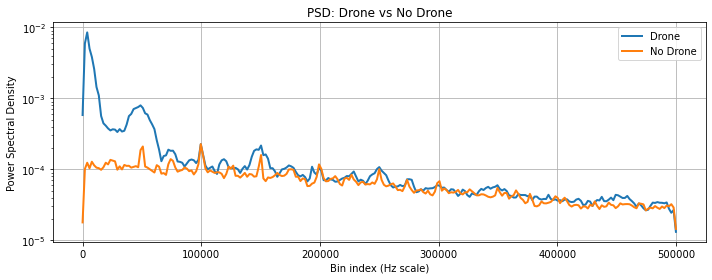

In [ ]:
plot_compare_psd(drone_segments[0]["df"], no_drone_segments[0]["df"])

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

def plot_wpd_energy(df, wavelet="sym5", maxlevel=4):
    """
    Beregn og plott energien i hver WPD-node fra et helt segment.
    
    Parameters:
    - df: long-format DataFrame fra ett segment
    - wavelet: hvilken wavelet som skal brukes (f.eks. 'db4', 'haar', 'sym5')
    - maxlevel: dybden på WPD-treet
    """
    # Samle alle sweep power-verdier til én vektor
    powers = []
    for ts in df['timestamp'].unique():
        sweep = df[df['timestamp'] == ts]
        powers.append(sweep['power'].values)
    signal = np.concatenate(powers)

    # Utfør Wavelet Packet Decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)

    # Samle energien i hver node på siste nivå
    nodes = wp.get_level(maxlevel, order="freq")
    energies = [np.sum(np.square(node.data)) for node in nodes]
    labels = [node.path for node in nodes]

    # Plot energi per node
    plt.figure(figsize=(10, 4))
    plt.bar(labels, energies)
    plt.title(f"WPD Energi per node – Wavelet: {wavelet}, Level: {maxlevel}")
    plt.xlabel("Wavelet-pakke-node")
    plt.ylabel("Energi")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


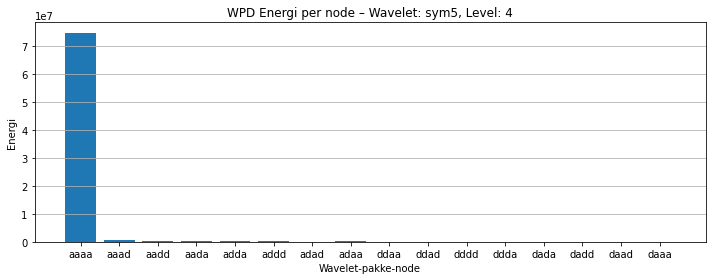

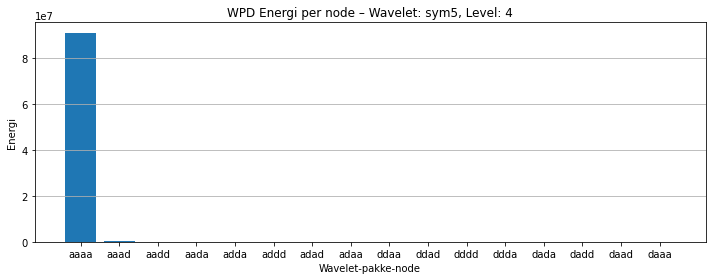

In [ ]:
plot_wpd_energy(drone_segments[2]["df"])
plot_wpd_energy(no_drone_segments[0]["df"])

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def plot_wpd_energy_log(df, wavelet="db4", maxlevel=3):
    """
    Plott normalisert og log-skalert WPD-energi for ett segment.
    
    Parameters:
    - df: DataFrame med RF-power-data i long-format
    - wavelet: wavelet-type (f.eks. 'db4', 'haar', 'sym5')
    - maxlevel: dybde på wavelet-pakke-treet
    """
    # Samle alle sweep power-verdier
    powers = []
    for ts in df['timestamp'].unique():
        sweep = df[df['timestamp'] == ts]
        powers.append(sweep['power'].values)
    signal = np.concatenate(powers)

    # Wavelet packet decomposition
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')
    
    # Beregn og normaliser energi
    energies = np.array([np.sum(np.square(node.data)) for node in nodes])
    labels = [node.path for node in nodes]
    energies /= np.sum(energies)  # normalisering

    # Log-skalert plot
    plt.figure(figsize=(10, 4))
    plt.bar(labels, energies)
    plt.yscale("log")
    plt.title(f"WPD – normalisert log-energi (wavelet: {wavelet}, level: {maxlevel})")
    plt.xlabel("WPD-node")
    plt.ylabel("Relativ energi (log-skala)")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


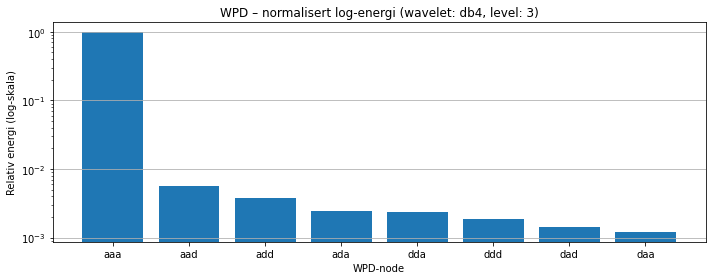

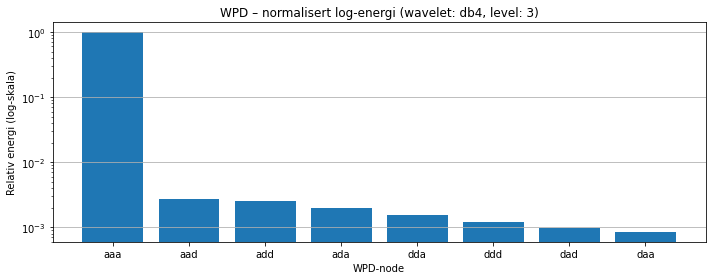

In [ ]:
plot_wpd_energy_log(drone_segments[3]["df"])
plot_wpd_energy_log(no_drone_segments[0]["df"])

In [ ]:
import pywt
import numpy as np

def extract_wpd_features(df, wavelet="db4", maxlevel=3, normalize=True):
    """
    Returner WPD-energier som featurevektor for ett segment.
    
    Parameters:
    - df: long-format RF-segment med 'power' og 'timestamp'
    - wavelet: wavelet-type (f.eks. 'db4', 'haar')
    - maxlevel: nivådybde på WPD
    - normalize: hvis True, normaliser energiene slik at summen er 1
    
    Returns:
    - features: 1D numpy array med energier fra hver WPD-node
    """
    powers = []
    for ts in df['timestamp'].unique():
        sweep = df[df['timestamp'] == ts]
        powers.append(sweep['power'].values)
    signal = np.concatenate(powers)

    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')
    energies = np.array([np.sum(np.square(node.data)) for node in nodes])
    
    if normalize:
        total = np.sum(energies)
        if total > 0:
            energies /= total
    
    return energies


In [ ]:
feat_drone = extract_wpd_features(drone_segments[0]["df"])
feat_nodrone = extract_wpd_features(no_drone_segments[0]["df"])

print("Drone features:", feat_drone)
print("No drone features:", feat_nodrone)


Drone features: [0.98179433 0.00544938 0.00383715 0.00236215 0.00230269 0.00179637
 0.00131014 0.0011478 ]
No drone features: [9.88185507e-01 2.71867365e-03 2.56476858e-03 1.99438874e-03
 1.54102502e-03 1.18463746e-03 9.60616793e-04 8.50383092e-04]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(X, y, feature_names=None):
    """
    Plot fordeling av hver feature for drone vs no_drone.
    
    Parameters:
    - X: np.array eller DataFrame (n_samples, n_features)
    - y: liste/array med 'drone' eller 'no_drone'
    - feature_names: liste med navn (valgfritt)
    """
    df = pd.DataFrame(X, columns=feature_names if feature_names else [f"f{i}" for i in range(X.shape[1])])
    df["label"] = y

    for col in df.columns[:-1]:
        plt.figure(figsize=(6, 3))
        sns.kdeplot(data=df, x=col, hue="label", fill=True, common_norm=False, alpha=0.5)
        plt.title(f"Feature: {col}")
        plt.grid()
        plt.tight_layout()
        plt.show()


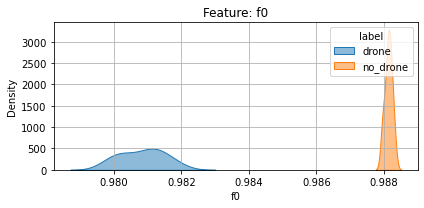

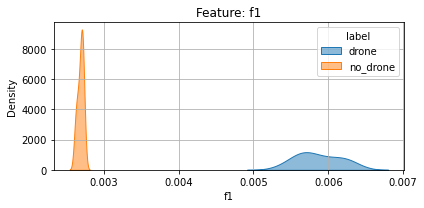

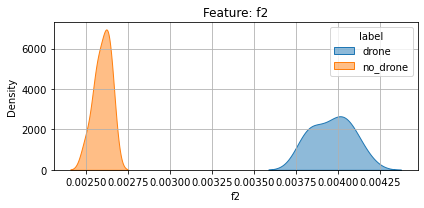

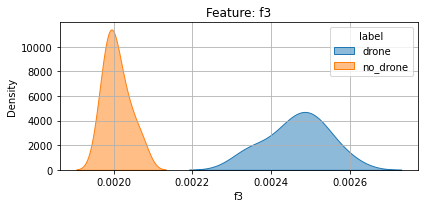

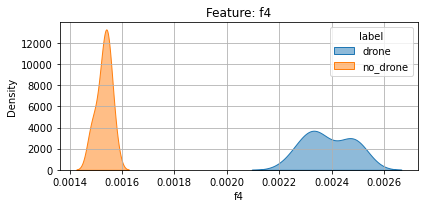

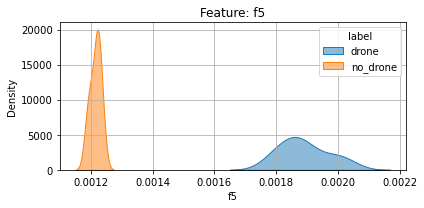

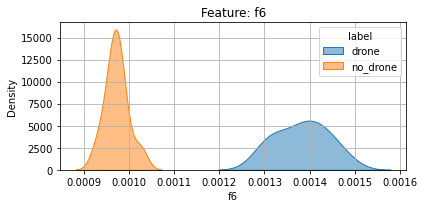

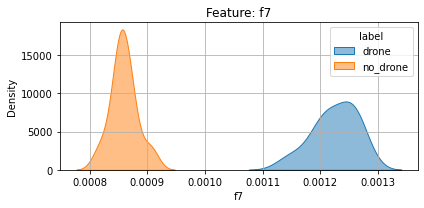

In [ ]:
# Lag X og y først fra segmentene (dersom du ikke har gjort det)
X = []
y = []
for s in drone_segments[:10]:
    X.append(extract_wpd_features(s["df"]))
    y.append("drone")
for s in no_drone_segments[:10]:
    X.append(extract_wpd_features(s["df"]))
    y.append("no_drone")

X = np.array(X)

# Plott feature-fordelinger
plot_feature_distributions(X, y)


In [ ]:
def plot_feature_correlation(X, feature_names=None):
    """
    Plot heatmap med korrelasjonsmatrise for feature-sett.
    """
    df = pd.DataFrame(X, columns=feature_names if feature_names else [f"f{i}" for i in range(X.shape[1])])
    corr = df.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={'label': 'Korrelasjon'})
    plt.title("Feature-korrelasjonsmatrise")
    plt.tight_layout()
    plt.show()


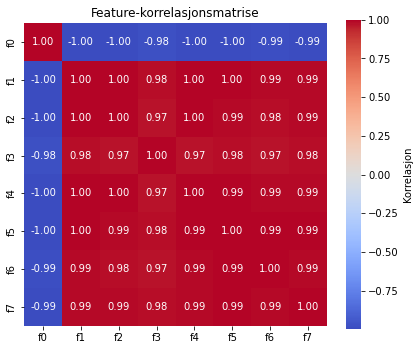

In [ ]:
plot_feature_correlation(X)
